# Transformer
source: https://arxiv.org/abs/1706.03762

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
from os.path import join
from fastai.vision import *

sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))
from cycle_gan import *

### Embedding layer

In [3]:
#export
class PositionalEncoding(nn.Module):
    '''Positional encoding layer using sinusoid curve'''
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1) # sinusoid
        return enc

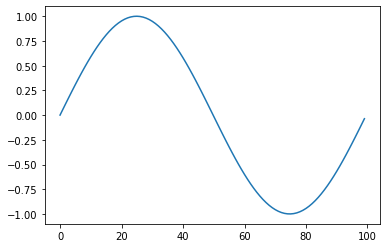

In [4]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
plt.plot(res[:,3])

In [5]:
#export
class TransformerEmbedding(nn.Module):
    '''Transformer embedding layer (embedding + positional encoding + dropout)'''
    def __init__(self, vocab_size, emb_size, dropout=0.):
        super().__init__()
        self.emb_size = emb_size
        self.embedding = embedding(vocab_size, emb_size)
        self.pos_encoding = PositionalEncoding(emb_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp): 
        position = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.dropout(self.embedding(inp) * math.sqrt(self.emb_size) + self.pos_encoding(position))

## Feed Forward

In [6]:
#export
def feed_forward(model_dim, inner_dim, drop_ff=0., double_drop=True):
    '''Feed forward layer after multi-headed attention (2 * Linear + skip connection + layer norm)'''
    layers = [nn.Linear(model_dim, inner_dim), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(drop_ff))
    layers += [nn.Linear(inner_dim, model_dim), nn.Dropout(drop_ff)]
    return SequentialEx(*layers, MergeLayer(), nn.LayerNorm(model_dim))

In [7]:
#export
class MultiHeadAttention(nn.Module):
    '''Multi-Head Attention with key, query, value'''
    def __init__(self, num_head, model_dim, head_dim=None, drop_res=0., drop_att=0., 
                 bias=True, scale=True):
        super().__init__()
        head_dim = head_dim if head_dim else model_dim//num_head
        self.num_head, self.head_dim, self.scale = num_head, head_dim, scale
        
        # identically shaped linear layers for query, key, and value
        self.q_lin = nn.Linear(model_dim, num_head * head_dim, bias=bias)
        self.k_lin = nn.Linear(model_dim, num_head * head_dim, bias=bias)
        self.v_lin = nn.Linear(model_dim, num_head * head_dim, bias=bias)
        
        self.out = nn.Linear(num_head * head_dim, model_dim, bias=bias)
        self.drop_att = nn.Dropout(drop_att)
        self.drop_res = nn.Dropout(drop_res)
        self.layer_norm = nn.LayerNorm(model_dim)
    
    def forward(self, q, k, v, mask=None):
        batch_size, seq_len = q.shape[0], q.shape[1]
        # linear pass + reshape
        q_out, k_out, v_out = self.q_lin(q), self.k_lin(k), self.v_lin(v)
        q_out, k_out, v_out = map(lambda x: x.view(batch_size, x.shape[1], self.num_head, self.head_dim), (q_out, k_out, v_out))
        q_out, k_out, v_out = q_out.permute(0, 2, 1, 3), k_out.permute(0, 2, 3, 1), v_out.permute(0, 2, 1, 3)
        # compute QxK and apply scaling + masking
        att_scores = q_out @ k_out / self.head_dim ** 0.5 if self.scale else q_out @ k_out
        if mask: att_scores = att_scores.masked_fill(mask, -float('inf'))

        att_soft = self.drop_att(F.softmax(att_scores, dim=-1))
        att_vec = torch.matmul(att_soft, v_out)
        att_vec = att_vec.permute(0, 2, 1, 3).view(batch_size, seq_len, -1)
        res = q + self.drop_res(self.out(att_vec))
        return self.layer_norm(res)

In [8]:
#export
class TransEncoder(nn.Module):
    '''Encoder block of a Transformer model'''
    #Can't use Sequential directly cause more than one input...
    def __init__(self, num_head, model_dim, head_dim, inner_dim, drop_res=0., drop_att=0., 
                 drop_ff=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.multiHeadAttention = MultiHeadAttention(num_head, model_dim, head_dim, drop_res, 
                                                     drop_att, bias, scale)
        self.feed_fwd = feed_forward(model_dim, inner_dim, drop_ff, double_drop)
    
    def forward(self, inp, mask=None): 
        return self.feed_fwd(self.multiHeadAttention(inp, inp, inp, mask=mask))

In [9]:
#export
class TransDecoder(nn.Module):
    '''Decoder block of a Transformer model'''
    #Can't use Sequential directly cause more than one input...
    def __init__(self, num_head, model_dim, head_dim, inner_dim, drop_res=0., drop_att=0., 
                 drop_ff=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.multiHeadAttention1 = MultiHeadAttention(num_head, model_dim, head_dim, drop_res, 
                                                      drop_att, bias, scale)
        self.multiHeadAttention2 = MultiHeadAttention(num_head, model_dim, head_dim, drop_res,
                                                      drop_att, bias, scale)
        self.feed_fwd = feed_forward(model_dim, inner_dim, drop_ff, double_drop)
    
    def forward(self, x, enc, mask_in=None, mask_out=None): 
        y = self.multiHeadAttention1(x, x, x, mask_out)
        return self.feed_fwd(self.multiHeadAttention2(y, enc, enc, mask_in))

In [10]:
#export
class Transformer(nn.Module):
    '''Transformer model'''
    def __init__(self, vocab_size, out_size, n_layers=6, num_head=8, model_dim=256, 
                 head_dim=32, inner_dim=1024, drop_inp=0.1, drop_res=0.1, drop_att=0.1, 
                 drop_ff=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        super().__init__()
        self.enc_emb = TransformerEmbedding(vocab_size, model_dim, drop_inp)
        self.dec_emb = TransformerEmbedding(out_size, model_dim, 0.)
        self.encoder = nn.ModuleList([TransEncoder(num_head, model_dim, head_dim, inner_dim, 
                                                   drop_res, drop_att, drop_ff, bias, scale, 
                                                   double_drop) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([TransDecoder(num_head, model_dim, head_dim, inner_dim, 
                                                   drop_res, drop_att, drop_ff, bias, scale, 
                                                   double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(model_dim, out_size)
        self.out.weight = self.dec_emb.embedding.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_in  = (inp == self.pad_idx)[:,None,:,None]
        mask_out = torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None, None]
        
        enc_out = self.enc_emb(inp)
        for enc_block in self.encoder: 
            enc_out = enc_block(enc_out, mask_in)
            
        dec_out = self.dec_emb(out)
        for dec_block in self.decoder: 
            dec_out = dec_block(dec_out, enc_out, mask_in, mask_out)
            
        return self.out(dec_out)

In [11]:
transformer = Transformer(1024, 1024, model_dim=256)
transformer

Transformer(
  (enc_emb): TransformerEmbedding(
    (embedding): Embedding(1024, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_emb): TransformerEmbedding(
    (embedding): Embedding(1024, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ModuleList(
    (0): TransEncoder(
      (multiHeadAttention): MultiHeadAttention(
        (q_lin): Linear(in_features=256, out_features=256, bias=True)
        (k_lin): Linear(in_features=256, out_features=256, bias=True)
        (v_lin): Linear(in_features=256, out_features=256, bias=True)
        (out): Linear(in_features=256, out_features=256, bias=True)
        (drop_att): Dropout(p=0.1, inplace=False)
        (drop_res): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (feed_fwd): SequentialEx(
        (layers): ModuleList(
          (0): Linear(in_features=256, ou